In [1]:
# Load trained NN filter 
from NNFilter import *
import time 

tic = time.time()
ML_file = 'nn_model/LaxSodNormSIAC0_ValidationSIAC0_TophatTrain1138_LaxSodVal50_B200_L7_Ch128_K7_LR1.0e-04.pt'
MLfilter = load_nn_filter(ML_file)
ml_label = 'trainTophat_valLaxSod50'

toc = time.time()
print(f"Loaded NN filter in {toc - tic:.2f} seconds.")

Loaded NN filter in 0.01 seconds.


/Users/sorayaterrab/PhD-Code/hybrid-filter/NNFilter.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  MLfilter.load_state_dict(torch.load(nn_filename, map_location=torch.

*** Warning: JSAnimation not found
*** Warning: JSAnimation not found
Degree:  2
Density Errors: SineEntropy p=2 discontinuity0
        l2    -      l_inf
Raw : 1.62e-01 & 3.28e-01
SIAC: 1.12e-01 & 2.99e-01
Hybrid: 1.22e-01 & 3.80e-01


<Figure size 600x400 with 0 Axes>

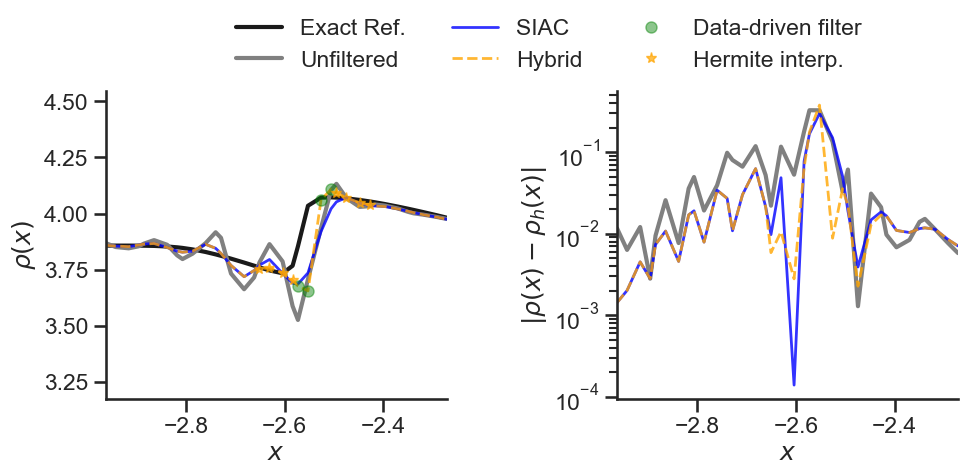

Velocity Errors: SineEntropy p=2 discontinuity0
        l2    -      l_inf
Raw : 8.21e-02 & 1.72e-01
SIAC: 5.52e-02 & 1.47e-01
Hybrid: 6.17e-02 & 1.91e-01


<Figure size 600x400 with 0 Axes>

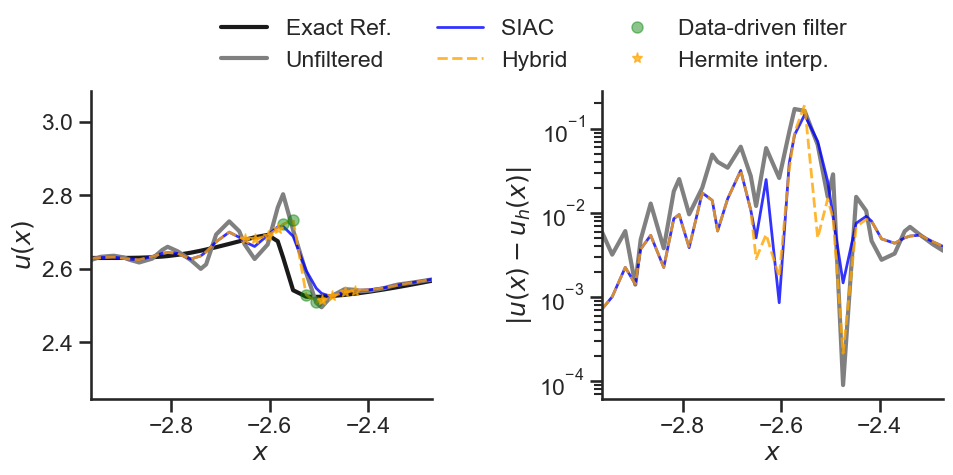

Pressure Errors: SineEntropy p=2 discontinuity0
        l2    -      l_inf
Raw : 6.00e-01 & 1.23e+00
SIAC: 4.17e-01 & 1.11e+00
Hybrid: 4.57e-01 & 1.42e+00


<Figure size 600x400 with 0 Axes>

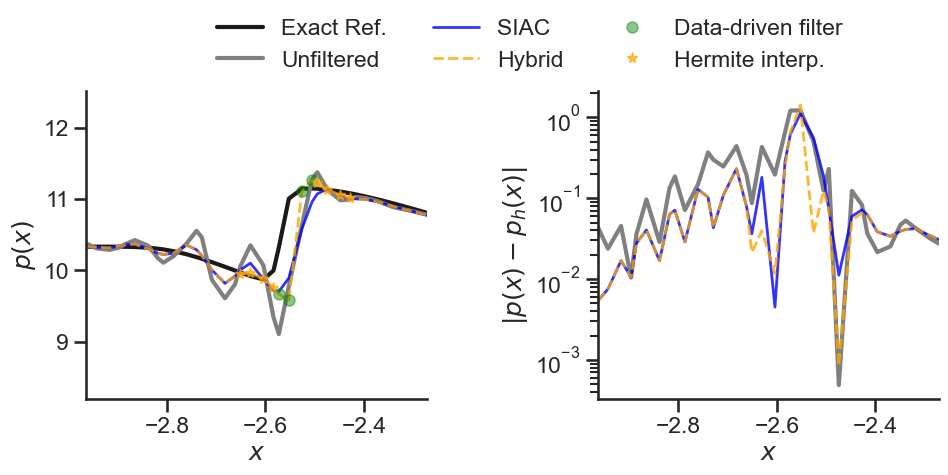

Entropy Errors: SineEntropy p=2 discontinuity0
        l2    -      l_inf
Raw : 8.96e-04 & 1.44e-03
SIAC: 1.08e-03 & 2.14e-03
Hybrid: 9.08e-04 & 1.85e-03


<Figure size 600x400 with 0 Axes>

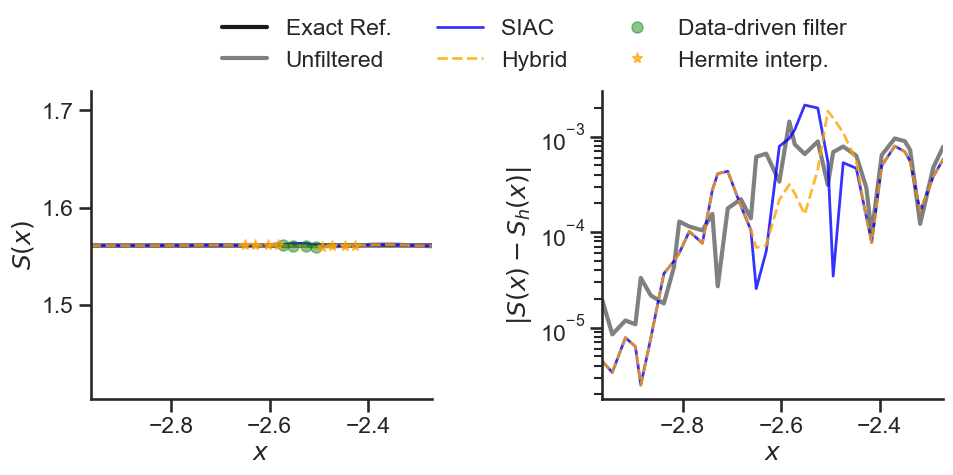

Total time taken for all discontinuities:  5.390991687774658  seconds


In [ ]:
# Apply NN filter to CFD test data: Individual sample at final time, single degree -- LAX, SOD, and SINE-ENTROPY
from Data import *
from SIACFilter import *
from DiscontinuityDetection import *
import numpy as np
import seaborn as sns
import os
from ClawpackRiemannExact import generate_exact_soln



sns.set()
sns.set(rc={'figure.figsize':(6,4)})
sns.color_palette('bright')
sns.set_style("white")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_style("ticks", rc=custom_params)
sns.set_context("talk")

plt_label = 'fig'

# Parameters
N = 128
n_levels = int(np.log2(N))
pts_per_cell = 4
xR = 5
xL = -5
h = (xR-xL)/N
grid, grid_spacing = generateGrid(n_levels, n_levels, 1, x_left=xL, x_right=xR)
gamma = 1.4
ghost_cells = 10
smoothness_global = -1
smoothness_disc = -1
siac_kernel_size_global = '0'
siac_kernel_size_disc = '0'
cell_interp = 1

if N >= 128:
    tc_gap = 4
    kernel_width = 4
else:
    tc_gap = 2
    kernel_width = 2

# >>>>>>>>>>>>>>>>> DEGREE <<<<<<<<<<<<<<<<<<<
p = 2
print('Degree: ', p)

# ---->>> Hermite interpolation for adjacent cells
pts_tc = min(2, p)
pts_disc = 1

# >>>>>>>>>>> INITIAL CONDITIONS <<<<<<<<<<<<
# -- Lax
label='Lax'
data_label = 'cfd_data/Lax/Lax_TVB50_T1.3_N128_p'
data = np.load(data_label + str(p)+ '.npz')

rho_l, u_l, p_l = 0.445, 0.698, 3.528
rho_r, u_r, p_r = 0.5, 0., 0.571
final_time = 1.3
threshold = 0.05

# # -- Sod
# label='Sod'
# data_label = 'cfd_data/Sod/Sod_TVB30_T2.0_N128_p'
# data = np.load(data_label + str(p)+ '.npz')

# rho_l, u_l, p_l = 1.0, 0.0, 1.0
# rho_r, u_r, p_r = 0.125, 0.0, 0.1
# final_time = 2.0
# threshold = 0.05

# # -- SineEntropy
# label='SineEntropy'
# data_label = 'cfd_data/SineEntropy/SineEntropy_TVB100_T1.8_N128_p'
# data = np.load(data_label + str(p)+ '.npz')
# final_time = 1.8
# threshold = 0.9 #0.9 for p=1, 3, 4, #0.1 for p=2


# >>>>>>>>>  PRIMITIVE VARIABLES <<<<<<<<<<<<
evaluation_pts = data['plot_grid'][0,:]
modes_simulation = data['coeffs']
grid_pts, density = computeApprox(modes_simulation[:, :, 0].T, grid, grid_spacing, num_pts_per_cell=pts_per_cell)
grid_pts, momentum = computeApprox(modes_simulation[:, :, 1].T, grid, grid_spacing, num_pts_per_cell=pts_per_cell)
grid_pts, energy = computeApprox(modes_simulation[:, :, 2].T, grid, grid_spacing, num_pts_per_cell=pts_per_cell)
velocity_quad_nodes = momentum/density
pressure_quad_nodes = (gamma - 1.0) * (energy - 0.5 * density * velocity_quad_nodes ** 2)
entropy_quad_nodes = pressure_quad_nodes/(density**gamma)

density_raw_modes = modes_simulation[:, 1:-1, 0]
velocity_raw_modes = computeModes(velocity_quad_nodes[0,:].reshape((1,1, -1)), np.array([p]), num_pts_per_cell=pts_per_cell)[0].T
pressure_raw_modes = computeModes(pressure_quad_nodes[0,:].reshape((1,1, -1)), np.array([p]), num_pts_per_cell=pts_per_cell)[0].T
entropy_raw_modes = computeModes(entropy_quad_nodes[0,:].reshape((1,1, -1)), np.array([p]), num_pts_per_cell=pts_per_cell)[0].T

_, velocity = computeApprox(velocity_raw_modes.T, grid, grid_spacing, num_pts_per_cell=pts_per_cell)
_, pressure = computeApprox(pressure_raw_modes.T, grid, grid_spacing, num_pts_per_cell=pts_per_cell)
_, entropy = computeApprox(entropy_raw_modes.T, grid, grid_spacing, num_pts_per_cell=pts_per_cell)


# >>>>>>>>>>>>>>>>> EXACT  <<<<<<<<<<<<<<<<<<<

# # -- LAX/SOD: Generate LAX/SOD Exact solution
if label == 'Lax' or label == 'Sod':
    exact = generate_exact_soln(evaluation_pts, rho_l=rho_l, u_l=u_l, p_l=p_l, 
                                rho_r=rho_r, u_r=u_r, p_r=p_r,
                                t=final_time)

    exact_den = exact[0]
    exact_vel = exact[1]
    exact_pres = exact[2]
    exact_mom = exact_den*exact_vel
    exact_eng = 0.5*exact_den*exact_vel**2 + exact_pres/(gamma - 1.0)
    exact_entropy = exact_pres/(exact_den**gamma)

else: 
    # -- SINE-ENTROPY: *Approximate* Exact solution
    exact_filename = ['cfd_data/SineEntropy/exact/SineEntropy.npz']
    data_exact = np.load(exact_filename[0], allow_pickle=True)
    exact_comp = data_exact['exact']
    exact_grid = data_exact['mesh']

    # --- Interpolating exact solution at evaluation points of approximation 
    exact_ref_grid = np.zeros(N*pts_per_cell)
    exact_ref_soln = np.zeros((N*pts_per_cell, 3))
    for pt in range(N*pts_per_cell): 
        xval = grid_pts[pt]
        error = exact_grid[0,:]-xval*np.ones(len(exact_grid[0,:]))
        index = list(np.where(abs(error)<1e-4))[0]
        if len(index)>1: 
            error1 = np.zeros(len(index))
            for j in range(len(index)): 
                error1[j] = abs(exact_grid[0,index[j]] - xval)
            
            new_index = np.where(error1 == min(error1))[0][0]
            index_final = index[new_index]

            exact_ref_grid[pt] = exact_grid[0,index_final]
            exact_ref_soln[pt, :] = exact_comp[index_final, :]
            
        else: 
            exact_ref_grid[pt] = exact_grid[0,index[0]]
            exact_ref_soln[pt, :] = exact_comp[index[0], :]

    # --- Exact quantities
    density_exact = exact_ref_soln[:, 0]
    velocity_exact = exact_ref_soln[:, 1]/exact_ref_soln[:, 0]
    pressure_exact = (gamma - 1.0) * (exact_ref_soln[:, 2] - 0.5 * density_exact * velocity_exact ** 2)

    exact_den = density_exact
    exact_vel = velocity_exact
    exact_pres = pressure_exact
    exact_entropy = pressure_exact/(density_exact**gamma)


# >>>>>>>>>>>>>>>>> COMPONENT <<<<<<<<<<<<<<<<<<<
# ---->>> Density
approx_den = density[0, :]
modes_den = np.zeros((1), dtype=object)
modes_den[0] = density_raw_modes

# ---->>> Momentum
approx_mom = momentum[0, :]
modes_mom = np.zeros((1), dtype=object)
modes_mom[0] = modes_simulation[:, 1:-1, 1]

# ---->>> Energy
approx_eng = energy[0, :]
modes_eng = np.zeros((1), dtype=object)
modes_eng[0] = modes_simulation[:, 1:-1, 2]

# ---->>> Velocity

approx_vel = velocity[0, :]
modes_vel = np.zeros((1), dtype=object)
modes_vel[0] = velocity_raw_modes

# ---->>> Pressure
approx_pres = pressure[0, :]
modes_pres = np.zeros((1), dtype=object)
modes_pres[0] = pressure_raw_modes

# ---->>> Entropy
approx_entropy = entropy[0, :]
modes_entropy = np.zeros((1), dtype=object)
modes_entropy[0] = entropy_raw_modes


# >>>>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<<<<<<

# Apply SIAC filter to the data
# ---->>> Density
filtered_global_den, modes_filtered_global_den, multiwavelets_global_den = apply_siac_filter(modes_den, smoothness_global, modes_type='cfd', filter_size=siac_kernel_size_global, ghost_cells=ghost_cells, N=N, pts_per_cell=pts_per_cell, xL=xL, xR=xR)
filtered_global_den = np.squeeze(filtered_global_den)
filtered_disc_den, modes_filtered_disc_den, multiwavelets_disc_den = apply_siac_filter(modes_den, smoothness_disc, modes_type='cfd', filter_size=siac_kernel_size_disc, ghost_cells=ghost_cells, N=N, pts_per_cell=pts_per_cell, xL=xL, xR=xR)
filtered_disc_den = np.squeeze(filtered_disc_den)

# ---->>> Momentum
filtered_global_mom, modes_filtered_global_mom, multiwavelets_global_mom = apply_siac_filter(modes_mom, smoothness_global, modes_type='cfd', filter_size=siac_kernel_size_global, ghost_cells=ghost_cells, N=N, pts_per_cell=pts_per_cell, xL=xL, xR=xR)
filtered_global_mom = np.squeeze(filtered_global_mom)
filtered_disc_mom, modes_filtered_disc_mom, multiwavelets_disc_mom = apply_siac_filter(modes_mom, smoothness_disc, modes_type='cfd', filter_size=siac_kernel_size_disc, ghost_cells=ghost_cells, N=N, pts_per_cell=pts_per_cell, xL=xL, xR=xR)
filtered_disc_mom = np.squeeze(filtered_disc_mom)

# ---->>> Energy
filtered_global_eng, modes_filtered_global_eng, multiwavelets_global_eng = apply_siac_filter(modes_eng, smoothness_global, modes_type='cfd', filter_size=siac_kernel_size_global, ghost_cells=ghost_cells, N=N, pts_per_cell=pts_per_cell, xL=xL, xR=xR)
filtered_global_eng = np.squeeze(filtered_global_eng)
filtered_disc_eng, modes_filtered_disc_eng, multiwavelets_disc_eng = apply_siac_filter(modes_eng, smoothness_disc, modes_type='cfd', filter_size=siac_kernel_size_disc, ghost_cells=ghost_cells, N=N, pts_per_cell=pts_per_cell, xL=xL, xR=xR)
filtered_disc_eng = np.squeeze(filtered_disc_eng)

# ---->>> Velocity
filtered_global_vel = filtered_global_mom/filtered_global_den
filtered_disc_vel = filtered_disc_mom/filtered_disc_den

# ---->>> Pressure
filtered_global_pres = (gamma - 1.0) * (filtered_global_eng - 0.5 * filtered_global_den * filtered_global_vel ** 2)
filtered_disc_pres = (gamma - 1.0) * (filtered_disc_eng - 0.5 * filtered_disc_den * filtered_disc_vel ** 2)

# ---->>> Entropy
filtered_global_entropy = filtered_global_pres/(filtered_global_den**gamma)
filtered_disc_entropy = filtered_disc_pres/(filtered_disc_den**gamma)


# Identify discontinuity windows
troubled_cells_den, _, _ = mask_thresholding_multiwavelets(multiwavelets_disc_den, threshold=threshold, N=N, seal_cell_gap=0)
tc_sets_den, filtering_windows_den = find_filtering_windows(troubled_cells_den[0], gap=tc_gap, kernel_size_by_cell=kernel_width, N=N)

hybrid_filtered_den = filtered_global_den.copy()
hybrid_filtered_mom = filtered_global_mom.copy()
hybrid_filtered_eng = filtered_global_eng.copy()

for i in range(len(tc_sets_den)):
    tc = tc_sets_den[i]

    window = np.arange(filtering_windows_den[i][0]*pts_per_cell, (filtering_windows_den[i][-1]+1)*pts_per_cell)

    # >>> Identify troubled cell with discontinuity
    fwd_diff = np.diff(filtered_disc_den[window])
    disc_loc = np.where(abs(fwd_diff)  ==  max(abs(fwd_diff)))[0]
    disc_loc_cell = (disc_loc // pts_per_cell)[0]
    cell_disc = disc_loc_cell + window[0]//pts_per_cell

    # >>> Cells adjacent to the troubled cell
    # ---- >>>> Cell(s) to the Left
    ind_interp_left_tc = np.arange((cell_disc-cell_interp)*pts_per_cell-pts_tc, (cell_disc-cell_interp)*pts_per_cell)
    ind_interp_left_disc = np.arange(cell_disc*pts_per_cell, cell_disc*pts_per_cell+pts_disc)
    ind_interp_left = np.concatenate((ind_interp_left_tc, ind_interp_left_disc))
    x_fit_left = evaluation_pts[ind_interp_left]

    # ---- >>>> Cell(s) to the Right
    ind_interp_right_disc = np.arange((cell_disc+1)*pts_per_cell-pts_disc, (cell_disc+1)*pts_per_cell)
    ind_interp_right_tc = np.arange((cell_disc+1+cell_interp)*pts_per_cell, (cell_disc+1+cell_interp)*pts_per_cell+pts_tc)
    ind_interp_right = np.concatenate((ind_interp_right_disc, ind_interp_right_tc))
    x_fit_right = evaluation_pts[ind_interp_right]

    # ---- >>>> Indices to interpolate
    indices_interp = np.concatenate((np.arange(ind_interp_left_tc[-1]+1, ind_interp_left_disc[0]), np.arange(ind_interp_right_disc[-1]+1,ind_interp_right_tc[0])))


    ##### DENSITY #####
    comp = 'Density'
    hybrid_filtered_den[window] = filtered_disc_den[window]

    # ---- Neural Network Filter
    min_val = np.min(filtered_disc_den[window])
    max_val = np.max(filtered_disc_den[window])
    normalized_input = (filtered_disc_den[window] - min_val)/(max_val - min_val)
    ml_filter_norm = MLfilter(torch.from_numpy(normalized_input.reshape((1,1,-1))).float()).detach().numpy()[0,0,:]
    ml_filter = ml_filter_norm*(max_val - min_val) + min_val
    hybrid_filtered_den[cell_disc*pts_per_cell:(cell_disc+1)*pts_per_cell] = ml_filter[disc_loc_cell*pts_per_cell:(disc_loc_cell+1)*pts_per_cell]

    # ---- Hermite interpolation for adjacent cells
    # ---- >>>> Cell(s) to the Left
    y_fit_left = hybrid_filtered_den[ind_interp_left]
    data_fit_coeff_left = np.polynomial.hermite.hermfit(x_fit_left, y_fit_left, pts_tc)
    data_fit_left = np.polynomial.hermite.Hermite(data_fit_coeff_left)
    nodal_fit_left = data_fit_left(evaluation_pts[ind_interp_left_tc[-1]+1:ind_interp_left_disc[0]])
    hybrid_filtered_den[ind_interp_left_tc[-1]+1:ind_interp_left_disc[0]] = nodal_fit_left

    # ---- >>>> Cell(s) to the Right
    y_fit_right = hybrid_filtered_den[ind_interp_right]
    data_fit_coeff_right = np.polynomial.hermite.hermfit(x_fit_right, y_fit_right, pts_tc)
    data_fit_right = np.polynomial.hermite.Hermite(data_fit_coeff_right)
    nodal_fit_right = data_fit_right(evaluation_pts[ind_interp_right_disc[-1]+1:ind_interp_right_tc[0]])
    hybrid_filtered_den[ind_interp_right_disc[-1]+1:ind_interp_right_tc[0]] = nodal_fit_right

    # ---- Plots and Error Results
    plt.figure()
    plt.subplots(1,2, figsize=(11, 4))
    plt.subplot(1,2,1)
    plt.plot(evaluation_pts[window], exact_den[window], '-k', alpha=1, linewidth=3,label='Exact Ref.')
    plt.plot(evaluation_pts[window], approx_den[window], '-', color='0.5', alpha=1, linewidth=3, label='Unfiltered')
    plt.plot(evaluation_pts[window], filtered_disc_den[window], '-', color='blue', alpha=0.8, linewidth=2, label='SIAC')
    plt.plot(evaluation_pts[window], hybrid_filtered_den[window], '--', color='orange', alpha=0.8, linewidth=2, label='Hybrid')
    plt.plot(evaluation_pts[cell_disc*pts_per_cell:(cell_disc+1)*pts_per_cell], hybrid_filtered_den[cell_disc*pts_per_cell:(cell_disc+1)*pts_per_cell], 'o', color='green', alpha=0.45, markersize=8, label='Data-driven filter')
    plt.plot(evaluation_pts[indices_interp], hybrid_filtered_den[indices_interp], '*', color='orange', alpha=0.7, markersize=8, label='Hermite interp.')
    plt.xlabel('$x$')
    plt.ylabel(r'$\rho(x)$')  
    plt.xlim(evaluation_pts[window][0], evaluation_pts[window][-1])
    plot_min = min(min(exact_den[window]), min(approx_den[window]), min(filtered_disc_den[window]), min(hybrid_filtered_den[window]))
    plot_max = max(max(exact_den[window]), max(approx_den[window]), max(filtered_disc_den[window]), max(hybrid_filtered_den[window]))
    plt.ylim(0.9*plot_min, 1.1*plot_max)
    plt.subplots_adjust(wspace=0.5)
    plt.legend()
    ax = plt.gca()
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(1.3, 1), ncol=3, title=None, frameon=False,
    )

    error_raw = abs(approx_den - exact_den)[window]
    error_siac = abs(filtered_disc_den - exact_den)[window]
    error_hybrid = abs(hybrid_filtered_den - exact_den)[window]

    # Print Errors l2 and l_inf
    print(comp + ' Errors: '+label+ ' p=' + str(p) + ' discontinuity' + str(i))
    print('        l2    -      l_inf')
    print('Raw :', "{:5.2e}".format(h**0.5*np.linalg.norm(error_raw, 2)), '&',  "{:5.2e}".format(np.amax(error_raw)))
    print('SIAC:', "{:5.2e}".format(h**0.5*np.linalg.norm(error_siac, 2)), '&', "{:5.2e}".format(np.amax(error_siac)))
    print('Hybrid:', "{:5.2e}".format(h**0.5*np.linalg.norm(error_hybrid, 2)), '&', "{:5.2e}".format(np.amax(error_hybrid)))

    plt.subplot(1,2,2)
    plt.semilogy(evaluation_pts[window], error_raw, '-', color='0.5', alpha=1, linewidth=3, label='Unfiltered')
    plt.semilogy(evaluation_pts[window], error_siac,  '-', color='blue', alpha=0.8, linewidth=2,label='SIAC')
    plt.semilogy(evaluation_pts[window], error_hybrid, '--', color='orange', alpha=0.8, linewidth=2, label='Hybrid')
    plt.xlabel('$x$')
    plt.ylabel(r'$|\rho(x) - \rho_h(x)|$')  
    plt.xlim(evaluation_pts[window][0], evaluation_pts[window][-1])
    # plt.savefig(plt_label+'/'+label+'/'+label+'_N'+str(N)+'_'+comp+'_'+ ml_label+'_SIAC_discSize'+siac_kernel_size_disc+'Smooth'+str(smoothness_disc)+
    #             '_p' + str(p) + '_disc'+str(i)+'.pdf', bbox_inches='tight')
    # plt.close()
    plt.show()

    ##### MOMENTUM #####
    comp = 'Momentum'
    hybrid_filtered_mom[window] = filtered_disc_mom[window]

    # ---- Neural Network Filter
    min_val = np.min(filtered_disc_mom[window])
    max_val = np.max(filtered_disc_mom[window])
    normalized_input = (filtered_disc_mom[window] - min_val)/(max_val - min_val)
    ml_filter_norm = MLfilter(torch.from_numpy(normalized_input.reshape((1,1,-1))).float()).detach().numpy()[0,0,:]
    ml_filter = ml_filter_norm*(max_val - min_val) + min_val
    hybrid_filtered_mom[cell_disc*pts_per_cell:(cell_disc+1)*pts_per_cell] = ml_filter[disc_loc_cell*pts_per_cell:(disc_loc_cell+1)*pts_per_cell]

    # ---- Hermite interpolation for adjacent cells
    # ---- >>>> Cell(s) to the Left
    y_fit_left = hybrid_filtered_mom[ind_interp_left]
    data_fit_coeff_left = np.polynomial.hermite.hermfit(x_fit_left, y_fit_left, pts_tc)
    data_fit_left = np.polynomial.hermite.Hermite(data_fit_coeff_left)
    nodal_fit_left = data_fit_left(evaluation_pts[ind_interp_left_tc[-1]+1:ind_interp_left_disc[0]])
    hybrid_filtered_mom[ind_interp_left_tc[-1]+1:ind_interp_left_disc[0]] = nodal_fit_left

    # ---- >>>> Cell(s) to the Right
    y_fit_right = hybrid_filtered_mom[ind_interp_right]
    data_fit_coeff_right = np.polynomial.hermite.hermfit(x_fit_right, y_fit_right, pts_tc)
    data_fit_right = np.polynomial.hermite.Hermite(data_fit_coeff_right)
    nodal_fit_right = data_fit_right(evaluation_pts[ind_interp_right_disc[-1]+1:ind_interp_right_tc[0]])
    hybrid_filtered_mom[ind_interp_right_disc[-1]+1:ind_interp_right_tc[0]] = nodal_fit_right


    ##### ENERGY #####
    comp = 'Energy'
    hybrid_filtered_eng[window] = filtered_disc_eng[window]

    # ---- Neural Network Filter
    min_val = np.min(filtered_disc_eng[window])
    max_val = np.max(filtered_disc_eng[window])
    normalized_input = (filtered_disc_eng[window] - min_val)/(max_val - min_val)
    ml_filter_norm = MLfilter(torch.from_numpy(normalized_input.reshape((1,1,-1))).float()).detach().numpy()[0,0,:]
    ml_filter = ml_filter_norm*(max_val - min_val) + min_val
    hybrid_filtered_eng[cell_disc*pts_per_cell:(cell_disc+1)*pts_per_cell] = ml_filter[disc_loc_cell*pts_per_cell:(disc_loc_cell+1)*pts_per_cell]

    # ---- Hermite interpolation for adjacent cells
    # ---- >>>> Cell(s) to the Left
    y_fit_left = hybrid_filtered_eng[ind_interp_left]
    data_fit_coeff_left = np.polynomial.hermite.hermfit(x_fit_left, y_fit_left, pts_tc)
    data_fit_left = np.polynomial.hermite.Hermite(data_fit_coeff_left)
    nodal_fit_left = data_fit_left(evaluation_pts[ind_interp_left_tc[-1]+1:ind_interp_left_disc[0]])
    hybrid_filtered_eng[ind_interp_left_tc[-1]+1:ind_interp_left_disc[0]] = nodal_fit_left

    # ---- >>>> Cell(s) to the Right
    y_fit_right = hybrid_filtered_eng[ind_interp_right]
    data_fit_coeff_right = np.polynomial.hermite.hermfit(x_fit_right, y_fit_right, pts_tc)
    data_fit_right = np.polynomial.hermite.Hermite(data_fit_coeff_right)
    nodal_fit_right = data_fit_right(evaluation_pts[ind_interp_right_disc[-1]+1:ind_interp_right_tc[0]])
    hybrid_filtered_eng[ind_interp_right_disc[-1]+1:ind_interp_right_tc[0]] = nodal_fit_right
    
    ##### VELOCITY #####
    comp = 'Velocity'
    
    hybrid_filtered_vel = hybrid_filtered_mom/hybrid_filtered_den

    # ---- Plots and Error Results
    plt.figure()
    plt.subplots(1,2, figsize=(11, 4))
    plt.subplot(1,2,1)
    plt.plot(evaluation_pts[window], exact_vel[window], '-k', alpha=1, linewidth=3,label='Exact Ref.')
    plt.plot(evaluation_pts[window], approx_vel[window], '-', color='0.5', alpha=1, linewidth=3, label='Unfiltered')
    plt.plot(evaluation_pts[window], filtered_disc_vel[window], '-', color='blue', alpha=0.8, linewidth=2, label='SIAC')
    plt.plot(evaluation_pts[window], hybrid_filtered_vel[window], '--', color='orange', alpha=0.8, linewidth=2, label='Hybrid')
    plt.plot(evaluation_pts[cell_disc*pts_per_cell:(cell_disc+1)*pts_per_cell], hybrid_filtered_vel[cell_disc*pts_per_cell:(cell_disc+1)*pts_per_cell], 'o', color='green', alpha=0.45, markersize=8, label='Data-driven filter')
    plt.plot(evaluation_pts[indices_interp], hybrid_filtered_vel[indices_interp], '*', color='orange', alpha=0.7, markersize=8, label='Hermite interp.')
    plt.xlabel('$x$')
    plt.ylabel('$u(x)$')  
    plt.xlim(evaluation_pts[window][0], evaluation_pts[window][-1])
    plot_min = min(min(exact_vel[window]), min(approx_vel[window]), min(filtered_disc_vel[window]), min(hybrid_filtered_vel[window]))
    plot_max = max(max(exact_vel[window]), max(approx_vel[window]), max(filtered_disc_vel[window]), max(hybrid_filtered_vel[window]))
    if plot_min == 0:
        plt.ylim(-0.1, 1.1*plot_max)
    elif plot_min < 0:
        plt.ylim(2*plot_min, 1.1*plot_max)
    else:
        plt.ylim(0.9*plot_min, 1.1*plot_max)

    plt.subplots_adjust(wspace=0.5)
    plt.legend()
    ax = plt.gca()
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(1.3, 1), ncol=3, title=None, frameon=False,
    )

    error_raw = abs(approx_vel - exact_vel)[window]
    error_siac = abs(filtered_disc_vel - exact_vel)[window]
    error_hybrid = abs(hybrid_filtered_vel - exact_vel)[window]

    # Print Errors l2 and l_inf
    print(comp + ' Errors: '+label+ ' p=' + str(p) + ' discontinuity' + str(i))
    print('        l2    -      l_inf')
    print('Raw :', "{:5.2e}".format(h**0.5*np.linalg.norm(error_raw, 2)), '&',  "{:5.2e}".format(np.amax(error_raw)))
    print('SIAC:', "{:5.2e}".format(h**0.5*np.linalg.norm(error_siac, 2)), '&', "{:5.2e}".format(np.amax(error_siac)))
    print('Hybrid:', "{:5.2e}".format(h**0.5*np.linalg.norm(error_hybrid, 2)), '&', "{:5.2e}".format(np.amax(error_hybrid)))

    plt.subplot(1,2,2)
    plt.semilogy(evaluation_pts[window], error_raw, '-', color='0.5', alpha=1, linewidth=3, label='Unfiltered')
    plt.semilogy(evaluation_pts[window], error_siac,  '-', color='blue', alpha=0.8, linewidth=2,label='SIAC')
    plt.semilogy(evaluation_pts[window], error_hybrid, '--', color='orange', alpha=0.8, linewidth=2, label='Hybrid')
    plt.xlabel('$x$')
    plt.ylabel('$|u(x) - u_h(x)|$')  
    plt.xlim(evaluation_pts[window][0], evaluation_pts[window][-1])
    # plt.savefig(plt_label+'/'+label+'/'+label+'_N'+str(N)+'_'+comp+'_'+ ml_label+'_SIAC_discSize'+siac_kernel_size_disc+'Smooth'+str(smoothness_disc)+
    #             '_p' + str(p) + '_disc'+str(i)+'.pdf', bbox_inches='tight')
    # # plt.close()
    plt.show()


    ##### PRESSURE #####
    comp = 'Pressure'

    hybrid_filtered_pres = (gamma - 1.0) * (hybrid_filtered_eng - 0.5 * hybrid_filtered_den * hybrid_filtered_vel ** 2)

    # ---- Plots and Error Results
    plt.figure()
    plt.subplots(1,2, figsize=(11, 4))
    plt.subplot(1,2,1)
    plt.plot(evaluation_pts[window], exact_pres[window], '-k', alpha=1, linewidth=3,label='Exact Ref.')
    plt.plot(evaluation_pts[window], approx_pres[window], '-', color='0.5', alpha=1, linewidth=3, label='Unfiltered')
    plt.plot(evaluation_pts[window], filtered_disc_pres[window], '-', color='blue', alpha=0.8, linewidth=2, label='SIAC')
    plt.plot(evaluation_pts[window], hybrid_filtered_pres[window], '--', color='orange', alpha=0.8, linewidth=2, label='Hybrid')
    plt.plot(evaluation_pts[cell_disc*pts_per_cell:(cell_disc+1)*pts_per_cell], hybrid_filtered_pres[cell_disc*pts_per_cell:(cell_disc+1)*pts_per_cell], 'o', color='green', alpha=0.45, markersize=8, label='Data-driven filter')
    plt.plot(evaluation_pts[indices_interp], hybrid_filtered_pres[indices_interp], '*', color='orange', alpha=0.7, markersize=8, label='Hermite interp.')
    plt.xlabel('$x$')
    plt.ylabel('$p(x)$')  
    plt.xlim(evaluation_pts[window][0], evaluation_pts[window][-1])
    plot_min = min(min(exact_pres[window]), min(approx_pres[window]), min(filtered_disc_pres[window]), min(hybrid_filtered_pres[window]))
    plot_max = max(max(exact_pres[window]), max(approx_pres[window]), max(filtered_disc_pres[window]), max(hybrid_filtered_pres[window]))
    plt.ylim(0.9*plot_min, 1.1*plot_max)
    plt.subplots_adjust(wspace=0.5)
    plt.legend()
    ax = plt.gca()
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(1.3, 1), ncol=3, title=None, frameon=False,
    )

    error_raw = abs(approx_pres - exact_pres)[window]
    error_siac = abs(filtered_disc_pres - exact_pres)[window]
    error_hybrid = abs(hybrid_filtered_pres - exact_pres)[window]

    # Print Errors l2 and l_inf
    print(comp + ' Errors: '+label+ ' p=' + str(p) + ' discontinuity' + str(i))
    print('        l2    -      l_inf')
    print('Raw :', "{:5.2e}".format(h**0.5*np.linalg.norm(error_raw, 2)), '&',  "{:5.2e}".format(np.amax(error_raw)))
    print('SIAC:', "{:5.2e}".format(h**0.5*np.linalg.norm(error_siac, 2)), '&', "{:5.2e}".format(np.amax(error_siac)))
    print('Hybrid:', "{:5.2e}".format(h**0.5*np.linalg.norm(error_hybrid, 2)), '&', "{:5.2e}".format(np.amax(error_hybrid)))

    plt.subplot(1,2,2)
    plt.semilogy(evaluation_pts[window], error_raw, '-', color='0.5', alpha=1, linewidth=3, label='Unfiltered')
    plt.semilogy(evaluation_pts[window], error_siac,  '-', color='blue', alpha=0.8, linewidth=2,label='SIAC')
    plt.semilogy(evaluation_pts[window], error_hybrid, '--', color='orange', alpha=0.8, linewidth=2, label='Hybrid')
    plt.xlabel('$x$')
    plt.ylabel('$|p(x) - p_h(x)|$')  
    plt.xlim(evaluation_pts[window][0], evaluation_pts[window][-1])
    # plt.savefig(plt_label+'/'+label+'/'+label+'_N'+str(N)+'_'+comp+'_'+ ml_label+'_SIAC_discSize'+siac_kernel_size_disc+'Smooth'+str(smoothness_disc)+
    #             '_p' + str(p) + '_disc'+str(i)+'.pdf', bbox_inches='tight')
    # plt.close()
    plt.show()


    ##### ENTROPY #####
    comp = 'Entropy'

    hybrid_filtered_entropy = hybrid_filtered_pres / (hybrid_filtered_den ** gamma)

    # ---- Plots and Error Results
    plt.figure()
    plt.subplots(1,2, figsize=(11, 4))
    plt.subplot(1,2,1)
    plt.plot(evaluation_pts[window], exact_entropy[window], '-k', alpha=1, linewidth=3,label='Exact Ref.')
    plt.plot(evaluation_pts[window], approx_entropy[window], '-', color='0.5', alpha=1, linewidth=3, label='Unfiltered')
    plt.plot(evaluation_pts[window], filtered_disc_entropy[window], '-', color='blue', alpha=0.8, linewidth=2, label='SIAC')
    plt.plot(evaluation_pts[window], hybrid_filtered_entropy[window], '--', color='orange', alpha=0.8, linewidth=2, label='Hybrid')
    plt.plot(evaluation_pts[cell_disc*pts_per_cell:(cell_disc+1)*pts_per_cell], hybrid_filtered_entropy[cell_disc*pts_per_cell:(cell_disc+1)*pts_per_cell], 'o', color='green', alpha=0.45, markersize=8, label='Data-driven filter')
    plt.plot(evaluation_pts[indices_interp], hybrid_filtered_entropy[indices_interp], '*', color='orange', alpha=0.7, markersize=8, label='Hermite interp.')
    plt.xlabel('$x$')
    plt.ylabel('$S(x)$')  
    plt.xlim(evaluation_pts[window][0], evaluation_pts[window][-1])
    plot_min = min(min(exact_entropy[window]), min(approx_entropy[window]), min(filtered_disc_entropy[window]), min(hybrid_filtered_entropy[window]))
    plot_max = max(max(exact_entropy[window]), max(approx_entropy[window]), max(filtered_disc_entropy[window]), max(hybrid_filtered_entropy[window]))
    plt.ylim(0.9*plot_min, 1.1*plot_max)
    plt.subplots_adjust(wspace=0.5)
    plt.legend()
    ax = plt.gca()
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(1.3, 1), ncol=3, title=None, frameon=False,
    )

    error_raw = abs(approx_entropy - exact_entropy)[window]
    error_siac = abs(filtered_disc_entropy - exact_entropy)[window]
    error_hybrid = abs(hybrid_filtered_entropy - exact_entropy)[window]

    # Print Errors l2 and l_inf
    print(comp + ' Errors: '+label+ ' p=' + str(p) + ' discontinuity' + str(i))
    print('        l2    -      l_inf')
    print('Raw :', "{:5.2e}".format(h**0.5*np.linalg.norm(error_raw, 2)), '&',  "{:5.2e}".format(np.amax(error_raw)))
    print('SIAC:', "{:5.2e}".format(h**0.5*np.linalg.norm(error_siac, 2)), '&', "{:5.2e}".format(np.amax(error_siac)))
    print('Hybrid:', "{:5.2e}".format(h**0.5*np.linalg.norm(error_hybrid, 2)), '&', "{:5.2e}".format(np.amax(error_hybrid)))

    plt.subplot(1,2,2)
    plt.semilogy(evaluation_pts[window], error_raw, '-', color='0.5', alpha=1, linewidth=3, label='Unfiltered')
    plt.semilogy(evaluation_pts[window], error_siac,  '-', color='blue', alpha=0.8, linewidth=2,label='SIAC')
    plt.semilogy(evaluation_pts[window], error_hybrid, '--', color='orange', alpha=0.8, linewidth=2, label='Hybrid')
    plt.xlabel('$x$')
    plt.ylabel('$|S(x) - S_h(x)|$')  
    plt.xlim(evaluation_pts[window][0], evaluation_pts[window][-1])
    # plt.savefig(plt_label+'/'+label+'/'+label+'_N'+str(N)+'_'+comp+'_'+ ml_label+'_SIAC_discSize'+siac_kernel_size_disc+'Smooth'+str(smoothness_disc)+
    #             '_p' + str(p) + '_disc'+str(i)+'.pdf', bbox_inches='tight')
    # plt.close()
    plt.show()


toc = time.time()
print('Total time taken for all discontinuities: ', toc - tic, ' seconds')

In [3]:
# APPLY HYBRID FILTER to ENTIRE DATASETS for ERROR ANALYSIS
from Data import *
from SIACFilter import *
from DiscontinuityDetection import *
import numpy as np
import seaborn as sns
import os
import pandas as pd

# >>>>>>>>> DATASET <<<<<<<<<<<<
N = 128
n_levels = int(np.log2(N))
pts_per_cell = 4
xR = 5
xL = -5
h = (xR-xL)/N
grid, grid_spacing = generateGrid(n_levels, n_levels, 1, x_left=xL, x_right=xR)
gamma = 1.4
ghost_cells = 10
smoothness_global = -1
smoothness_disc = -1
siac_kernel_size_global = '0'
siac_kernel_size_disc = '0'
cell_interp = 1
tc_gap = 4
kernel_width = 4


# # --- Lax: 84 samples from T=1 to T=1.3
sub_dir = 'Lax'
label = 'Lax_84samples_Tf1-1.3'
file_cfd = np.load('cfd_data/Lax/CFD_Lax_time1-1.3_N128_Samples84.npz', allow_pickle=True)
threshold = 0.05 

# # --- Sod: 65 samples from T=1.5 to T=2
# sub_dir = 'Sod'
# label = 'Sod_65samples_Tf1.5-2'
# file_cfd = np.load('cfd_data/Sod/CFD_Sod_time1.5-2.0_N128_Samples65.npz', allow_pickle=True)
# threshold = 0.1

# # --- Sine-Entropy: 84 samples from T=1.5 to T=1.8
# sub_dir = 'SineEntropy'
# label = 'SineEntropy_84samples_Tf1.5-1.8'
# file_cfd = np.load('cfd_data/SineEntropy/CFD_SineEntropy_time1.5-1.8_N128_Samples84.npz', allow_pickle=True)
# threshold = 0.9 

# >>>>>>>>>>>>>>>>> COMPONENT <<<<<<<<<<<<<<<<<<<
# ---->>> Density
approx_den = file_cfd['raw_density']
exact_den = file_cfd['exact_density']
modes_den = file_cfd['raw_density_modes']
times_cfd = file_cfd['times']

# ---->>> Momentum
approx_mom = file_cfd['raw_momentum']
exact_mom = file_cfd['exact_momentum']
modes_mom = file_cfd['raw_momentum_modes']

# ---->>> Energy
approx_eng = file_cfd['raw_energy']
exact_eng = file_cfd['exact_energy']
modes_eng = file_cfd['raw_energy_modes']

# ---->>> Velocity
approx_vel = file_cfd['raw_velocity']
exact_vel = file_cfd['exact_velocity']
modes_vel = file_cfd['raw_velocity_modes']

# ---->>> Pressure
approx_pres = file_cfd['raw_pressure']
exact_pres = file_cfd['exact_pressure']
modes_pres = file_cfd['raw_pressure_modes']

# >>>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<<

# Apply SIAC filter to the data
# ---->>> Density
filtered_global_den, modes_filtered_global_den, multiwavelets_global_den = apply_siac_filter(modes_den, smoothness_global, modes_type='cfd', filter_size=siac_kernel_size_global, ghost_cells=ghost_cells, N=N, pts_per_cell=pts_per_cell, xL=xL, xR=xR)
filtered_disc_den, modes_filtered_disc_den, multiwavelets_disc_den = apply_siac_filter(modes_den, smoothness_disc, modes_type='cfd', filter_size=siac_kernel_size_disc, ghost_cells=ghost_cells, N=N, pts_per_cell=pts_per_cell, xL=xL, xR=xR)

# ---->>> Momentum
filtered_global_mom, modes_filtered_global_mom, multiwavelets_global_mom = apply_siac_filter(modes_mom, smoothness_global, modes_type='cfd', filter_size=siac_kernel_size_global, ghost_cells=ghost_cells, N=N, pts_per_cell=pts_per_cell, xL=xL, xR=xR)
filtered_disc_mom, modes_filtered_disc_mom, multiwavelets_disc_mom = apply_siac_filter(modes_mom, smoothness_disc, modes_type='cfd', filter_size=siac_kernel_size_disc, ghost_cells=ghost_cells, N=N, pts_per_cell=pts_per_cell, xL=xL, xR=xR)

# ---->>> Energy
filtered_global_eng, modes_filtered_global_eng, multiwavelets_global_eng = apply_siac_filter(modes_eng, smoothness_global, modes_type='cfd', filter_size=siac_kernel_size_global, ghost_cells=ghost_cells, N=N, pts_per_cell=pts_per_cell, xL=xL, xR=xR)
filtered_disc_eng, modes_filtered_disc_eng, multiwavelets_disc_eng = apply_siac_filter(modes_eng, smoothness_disc, modes_type='cfd', filter_size=siac_kernel_size_disc, ghost_cells=ghost_cells, N=N, pts_per_cell=pts_per_cell, xL=xL, xR=xR)

# ---->>> Velocity
filtered_global_vel = filtered_global_mom/filtered_global_den
filtered_disc_vel = filtered_disc_mom/filtered_disc_den

# ---->>> Pressure
filtered_global_pres = (gamma - 1.0) * (filtered_global_eng - 0.5 * filtered_global_den * filtered_global_vel ** 2)
filtered_disc_pres = (gamma - 1.0) * (filtered_disc_eng - 0.5 * filtered_disc_den * filtered_disc_vel ** 2)


# Identify discontinuity windows from DENSITY data
troubled_cells_den, _, _ = mask_thresholding_multiwavelets(multiwavelets_disc_den, threshold=threshold, N=N, seal_cell_gap=0)

num_samples = approx_den.shape[0]

error_raw_den_l2 = []
error_raw_den_linf = []
error_siac_den_l2 = []
error_siac_den_linf = []
error_hybrid_den_l2 = []
error_hybrid_den_linf = []

error_raw_vel_l2 = []
error_raw_vel_linf = []
error_siac_vel_l2 = []
error_siac_vel_linf = []
error_hybrid_vel_l2 = []
error_hybrid_vel_linf = []

error_raw_pres_l2 = []
error_raw_pres_linf = []
error_siac_pres_l2 = []
error_siac_pres_linf = []
error_hybrid_pres_l2 = []
error_hybrid_pres_linf = []

for sample in range(num_samples):

    p = np.array(modes_den[sample]).shape[0]-1

    # ---->>> Hermite interpolation for adjacent cells
    pts_tc = min(2, p)
    pts_disc = 1
    
    # ---->>> Identify discontinuity windows
    tc_sets_den, filtering_windows_den = find_filtering_windows(troubled_cells_den[sample], gap=tc_gap, kernel_size_by_cell=kernel_width, N=N)

    hybrid_filtered_den = filtered_global_den[sample, :].copy()
    hybrid_filtered_mom = filtered_global_mom[sample, :].copy()
    hybrid_filtered_eng = filtered_global_eng[sample, :].copy()

    for i in range(len(tc_sets_den)):
        tc = tc_sets_den[i]

        window = np.arange(filtering_windows_den[i][0]*pts_per_cell, (filtering_windows_den[i][-1]+1)*pts_per_cell)

        # >>> Identify troubled cell with discontinuity
        fwd_diff = np.diff(filtered_disc_den[sample, window])
        disc_loc = np.where(abs(fwd_diff)  ==  max(abs(fwd_diff)))[0]
        disc_loc_cell = (disc_loc // pts_per_cell)[0]
        cell_disc = disc_loc_cell + window[0]//pts_per_cell

        # >>> Cells adjacent to the troubled cell
        # ---- >>>> Cell(s) to the Left
        ind_interp_left_tc = np.arange((cell_disc-cell_interp)*pts_per_cell-pts_tc, (cell_disc-cell_interp)*pts_per_cell)
        ind_interp_left_disc = np.arange(cell_disc*pts_per_cell, cell_disc*pts_per_cell+pts_disc)
        ind_interp_left = np.concatenate((ind_interp_left_tc, ind_interp_left_disc))
        x_fit_left = evaluation_pts[ind_interp_left]

        # ---- >>>> Cell(s) to the Right
        ind_interp_right_disc = np.arange((cell_disc+1)*pts_per_cell-pts_disc, (cell_disc+1)*pts_per_cell)
        ind_interp_right_tc = np.arange((cell_disc+1+cell_interp)*pts_per_cell, (cell_disc+1+cell_interp)*pts_per_cell+pts_tc)
        ind_interp_right = np.concatenate((ind_interp_right_disc, ind_interp_right_tc))
        x_fit_right = evaluation_pts[ind_interp_right]

        # ---- >>>> Indices to interpolate
        indices_interp = np.concatenate((np.arange(ind_interp_left_tc[-1]+1, ind_interp_left_disc[0]), np.arange(ind_interp_right_disc[-1]+1,ind_interp_right_tc[0])))


        ##### DENSITY #####
        comp = 'Density'
        hybrid_filtered_den[window] = filtered_disc_den[sample, window]

        # ---- Neural Network Filter
        min_val = np.min(filtered_disc_den[sample, window])
        max_val = np.max(filtered_disc_den[sample, window])
        normalized_input = (filtered_disc_den[sample, window] - min_val)/(max_val - min_val)
        ml_filter_norm = MLfilter(torch.from_numpy(normalized_input.reshape((1,1,-1))).float()).detach().numpy()[0,0,:]
        ml_filter = ml_filter_norm*(max_val - min_val) + min_val
        hybrid_filtered_den[cell_disc*pts_per_cell:(cell_disc+1)*pts_per_cell] = ml_filter[disc_loc_cell*pts_per_cell:(disc_loc_cell+1)*pts_per_cell]

        # ---- Hermite interpolation for adjacent cells
        # ---- >>>> Cell(s) to the Left
        y_fit_left = hybrid_filtered_den[ind_interp_left]
        data_fit_coeff_left = np.polynomial.hermite.hermfit(x_fit_left, y_fit_left, pts_tc)
        data_fit_left = np.polynomial.hermite.Hermite(data_fit_coeff_left)
        nodal_fit_left = data_fit_left(evaluation_pts[ind_interp_left_tc[-1]+1:ind_interp_left_disc[0]])
        hybrid_filtered_den[ind_interp_left_tc[-1]+1:ind_interp_left_disc[0]] = nodal_fit_left

        # ---- >>>> Cell(s) to the Right
        y_fit_right = hybrid_filtered_den[ind_interp_right]
        data_fit_coeff_right = np.polynomial.hermite.hermfit(x_fit_right, y_fit_right, pts_tc)
        data_fit_right = np.polynomial.hermite.Hermite(data_fit_coeff_right)
        nodal_fit_right = data_fit_right(evaluation_pts[ind_interp_right_disc[-1]+1:ind_interp_right_tc[0]])
        hybrid_filtered_den[ind_interp_right_disc[-1]+1:ind_interp_right_tc[0]] = nodal_fit_right

        # ---- Error Results
        error_raw = abs(approx_den[sample, :] - exact_den[sample, :])[window]
        error_siac = abs(filtered_disc_den[sample, :] - exact_den[sample, :])[window]
        error_hybrid = abs(hybrid_filtered_den - exact_den[sample, :])[window]

        error_raw_den_l2.append(h**0.5*np.linalg.norm(error_raw, 2))
        error_raw_den_linf.append(np.amax(error_raw))
        error_siac_den_l2.append(h**0.5*np.linalg.norm(error_siac, 2))
        error_siac_den_linf.append(np.amax(error_siac))
        error_hybrid_den_l2.append(h**0.5*np.linalg.norm(error_hybrid, 2))
        error_hybrid_den_linf.append(np.amax(error_hybrid))

        ##### MOMENTUM #####
        comp = 'Momentum'
        hybrid_filtered_mom[window] = filtered_disc_mom[sample, window]

        # ---- Neural Network Filter
        min_val = np.min(filtered_disc_mom[sample, window])
        max_val = np.max(filtered_disc_mom[sample, window])
        normalized_input = (filtered_disc_mom[sample, window] - min_val)/(max_val - min_val)
        ml_filter_norm = MLfilter(torch.from_numpy(normalized_input.reshape((1,1,-1))).float()).detach().numpy()[0,0,:]
        ml_filter = ml_filter_norm*(max_val - min_val) + min_val
        hybrid_filtered_mom[cell_disc*pts_per_cell:(cell_disc+1)*pts_per_cell] = ml_filter[disc_loc_cell*pts_per_cell:(disc_loc_cell+1)*pts_per_cell]

        # ---- Hermite interpolation for adjacent cells
        # ---- >>>> Cell(s) to the Left
        y_fit_left = hybrid_filtered_mom[ind_interp_left]
        data_fit_coeff_left = np.polynomial.hermite.hermfit(x_fit_left, y_fit_left, pts_tc)
        data_fit_left = np.polynomial.hermite.Hermite(data_fit_coeff_left)
        nodal_fit_left = data_fit_left(evaluation_pts[ind_interp_left_tc[-1]+1:ind_interp_left_disc[0]])
        hybrid_filtered_mom[ind_interp_left_tc[-1]+1:ind_interp_left_disc[0]] = nodal_fit_left

        # ---- >>>> Cell(s) to the Right
        y_fit_right = hybrid_filtered_mom[ind_interp_right]
        data_fit_coeff_right = np.polynomial.hermite.hermfit(x_fit_right, y_fit_right, pts_tc)
        data_fit_right = np.polynomial.hermite.Hermite(data_fit_coeff_right)
        nodal_fit_right = data_fit_right(evaluation_pts[ind_interp_right_disc[-1]+1:ind_interp_right_tc[0]])
        hybrid_filtered_mom[ind_interp_right_disc[-1]+1:ind_interp_right_tc[0]] = nodal_fit_right

        ##### ENERGY #####
        comp = 'Energy'
        hybrid_filtered_eng[window] = filtered_disc_eng[sample, window]
        
        # ---- Neural Network Filter
        min_val = np.min(filtered_disc_eng[sample, window])
        max_val = np.max(filtered_disc_eng[sample, window])
        normalized_input = (filtered_disc_eng[sample, window] - min_val)/(max_val - min_val)
        ml_filter_norm = MLfilter(torch.from_numpy(normalized_input.reshape((1,1,-1))).float()).detach().numpy()[0,0,:]
        ml_filter = ml_filter_norm*(max_val - min_val) + min_val
        hybrid_filtered_eng[cell_disc*pts_per_cell:(cell_disc+1)*pts_per_cell] = ml_filter[disc_loc_cell*pts_per_cell:(disc_loc_cell+1)*pts_per_cell]

        # ---- Hermite interpolation for adjacent cells
        # ---- >>>> Cell(s) to the Left
        y_fit_left = hybrid_filtered_eng[ind_interp_left]
        data_fit_coeff_left = np.polynomial.hermite.hermfit(x_fit_left, y_fit_left, pts_tc)
        data_fit_left = np.polynomial.hermite.Hermite(data_fit_coeff_left)
        nodal_fit_left = data_fit_left(evaluation_pts[ind_interp_left_tc[-1]+1:ind_interp_left_disc[0]])
        hybrid_filtered_eng[ind_interp_left_tc[-1]+1:ind_interp_left_disc[0]] = nodal_fit_left

        # ---- >>>> Cell(s) to the Right
        y_fit_right = hybrid_filtered_eng[ind_interp_right]
        data_fit_coeff_right = np.polynomial.hermite.hermfit(x_fit_right, y_fit_right, pts_tc)
        data_fit_right = np.polynomial.hermite.Hermite(data_fit_coeff_right)
        nodal_fit_right = data_fit_right(evaluation_pts[ind_interp_right_disc[-1]+1:ind_interp_right_tc[0]])
        hybrid_filtered_eng[ind_interp_right_disc[-1]+1:ind_interp_right_tc[0]] = nodal_fit_right
        
        ##### VELOCITY #####
        comp = 'Velocity'

        hybrid_filtered_vel = hybrid_filtered_mom/hybrid_filtered_den

        # ---- Error Results
        error_raw = abs(approx_vel[sample, :] - exact_vel[sample, :])[window]
        error_siac = abs(filtered_disc_vel[sample, :] - exact_vel[sample, :])[window]
        error_hybrid = abs(hybrid_filtered_vel - exact_vel[sample, :])[window]

        error_raw_vel_l2.append(h**0.5*np.linalg.norm(error_raw, 2))
        error_raw_vel_linf.append(np.amax(error_raw))
        error_siac_vel_l2.append(h**0.5*np.linalg.norm(error_siac, 2))
        error_siac_vel_linf.append(np.amax(error_siac))
        error_hybrid_vel_l2.append(h**0.5*np.linalg.norm(error_hybrid, 2))
        error_hybrid_vel_linf.append(np.amax(error_hybrid))

        ##### PRESSURE #####
        comp = 'Pressure'

        hybrid_filtered_pres = (gamma - 1.0) * (hybrid_filtered_eng - 0.5 * hybrid_filtered_den * hybrid_filtered_vel ** 2)
        
        # ---- Error Results
        error_raw = abs(approx_pres[sample, :] - exact_pres[sample, :])[window]
        error_siac = abs(filtered_disc_pres[sample, :] - exact_pres[sample, :])[window]
        error_hybrid = abs(hybrid_filtered_pres - exact_pres[sample, :])[window]

        error_raw_pres_l2.append(h**0.5*np.linalg.norm(error_raw, 2))
        error_raw_pres_linf.append(np.amax(error_raw))
        error_siac_pres_l2.append(h**0.5*np.linalg.norm(error_siac, 2))
        error_siac_pres_linf.append(np.amax(error_siac))
        error_hybrid_pres_l2.append(h**0.5*np.linalg.norm(error_hybrid, 2))
        error_hybrid_pres_linf.append(np.amax(error_hybrid))
       
n_samples = len(error_raw_den_l2) 

print('NN Model:', ml_label)

# ---->>> Density ERRORS and PLOTS <<<<---- 
print('Density QUANTILE Errors:', label, ', no. of discontinuity samples:', n_samples)
print ('______________________ l2_________________________      ___________________l_inf_________________________')
print('        Unfiltered    -      SIAC    -   Hybrid    ______   Unfiltered    -      SIAC    -   Hybrid  ')
print('75% Quantile :', "{:5.2e}".format(np.quantile(error_raw_den_l2, 0.75)), '&',  "{:5.2e}".format(np.quantile(error_siac_den_l2, 0.75)) , '&', "{:5.2e}".format(np.quantile(error_hybrid_den_l2, 0.75)), 
      ' & ' , "{:5.2e}".format(np.quantile(error_raw_den_linf, 0.75)), '&',  "{:5.2e}".format(np.quantile(error_siac_den_linf, 0.75)) , '&', "{:5.2e}".format(np.quantile(error_hybrid_den_linf, 0.75)))
print('Median :', "{:5.2e}".format(np.quantile(error_raw_den_l2, 0.5)), '&',  "{:5.2e}".format(np.quantile(error_siac_den_l2, 0.5)) , '&', "{:5.2e}".format(np.quantile(error_hybrid_den_l2, 0.5)), 
      ' & ' , "{:5.2e}".format(np.quantile(error_raw_den_linf, 0.5)), '&',  "{:5.2e}".format(np.quantile(error_siac_den_linf, 0.5)) , '&', "{:5.2e}".format(np.quantile(error_hybrid_den_linf, 0.5)))
print('25% Quantile :', "{:5.2e}".format(np.quantile(error_raw_den_l2, 0.25)), '&',  "{:5.2e}".format(np.quantile(error_siac_den_l2, 0.25)) , '&', "{:5.2e}".format(np.quantile(error_hybrid_den_l2, 0.25)), 
      ' & ' , "{:5.2e}".format(np.quantile(error_raw_den_linf, 0.25)), '&',  "{:5.2e}".format(np.quantile(error_siac_den_linf, 0.25)) , '&', "{:5.2e}".format(np.quantile(error_hybrid_den_linf, 0.25)))
print ('_________________________________________________________')

stack_den_raw_l2 = np.vstack([['Unfiltered', r'$\ell_2$', error_raw_den_l2[i]] for i in range(n_samples)])
stack_den_siac_l2 = np.vstack([['SIAC', r'$\ell_2$', error_siac_den_l2[i]] for i in range(n_samples)])
stack_den_hybrid_l2 = np.vstack([['Hybrid', r'$\ell_2$', error_hybrid_den_l2[i]] for i in range(n_samples)])
density_error_l2 = np.vstack((stack_den_raw_l2, stack_den_siac_l2, stack_den_hybrid_l2))

stack_den_raw_linf = np.vstack([['Unfiltered', r'$\ell_\infty$', error_raw_den_linf[i]] for i in range(n_samples)])
stack_den_siac_linf = np.vstack([['SIAC', r'$\ell_\infty$', error_siac_den_linf[i]] for i in range(n_samples)])
stack_den_hybrid_linf = np.vstack([['Hybrid', r'$\ell_\infty$', error_hybrid_den_linf[i]] for i in range(n_samples)])
density_error_linf = np.vstack((stack_den_raw_linf, stack_den_siac_linf, stack_den_hybrid_linf))

density_error = np.vstack((density_error_l2, density_error_linf))
density_error = pd.DataFrame(density_error, columns=['Approx.', 'Type', 'Error' ])
density_error['Error']= pd.to_numeric(density_error['Error'])

# np.savez(plt_label+'/'+sub_dir+'/'+label+'_Density_'+ml_label+'_TCD'+str(threshold)+'_SIAC_discSize'+siac_kernel_size_disc+'Smooth'+str(smoothness_disc)+'_Error', 
#          raw_l2=error_raw_den_l2, raw_linf=error_raw_den_linf, siac_l2=error_siac_den_l2, siac_linf=error_siac_den_linf, hybrid_l2=error_hybrid_den_l2, hybrid_linf=error_hybrid_den_linf,
#          dict=density_error)

hue_colors = {
    'Unfiltered': (0.5, 0.5, 0.5),
    'SIAC': (0, 0, 1), 
    'Hybrid':  (1, 0.647, 0)
}


ax = sns.violinplot(data=density_error, x="Type", y="Error", hue="Approx.",  inner_kws=dict(box_width=8, whis_width=2, color='k'), palette=hue_colors, log_scale=True, linewidth=1, fill=True, gap=0.1, split=True)
plt.xlabel('')
plt.ylim(5e-4, 50)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(0.55, 1), ncol=3, title=None, frameon=False,
)
# plt.savefig(plt_label+'/'+sub_dir+'/'+label+'_Density_'+ml_label+'_TCD'+str(threshold)+'_SIAC_discSize'+siac_kernel_size_disc+'Smooth'+str(smoothness_disc)+
#             '_error_violinplot_samples'+str(num_samples)+'_disc'+str(n_samples)+'.pdf', bbox_inches='tight')
plt.show()



print('Velocity QUANTILE Errors:', label, ', no. of discontinuity samples:', n_samples)
print ('______________________ l2_________________________      ___________________l_inf_________________________')
print('        Unfiltered    -      SIAC    -   Hybrid    ______   Unfiltered    -      SIAC    -   Hybrid  ')
print('75% Quantile :', "{:5.2e}".format(np.quantile(error_raw_vel_l2, 0.75)), '&',  "{:5.2e}".format(np.quantile(error_siac_vel_l2, 0.75)) , '&', "{:5.2e}".format(np.quantile(error_hybrid_vel_l2, 0.75)), 
      ' & ' , "{:5.2e}".format(np.quantile(error_raw_vel_linf, 0.75)), '&',  "{:5.2e}".format(np.quantile(error_siac_vel_linf, 0.75)) , '&', "{:5.2e}".format(np.quantile(error_hybrid_vel_linf, 0.75)))
print('Median :', "{:5.2e}".format(np.quantile(error_raw_vel_l2, 0.5)), '&',  "{:5.2e}".format(np.quantile(error_siac_vel_l2, 0.5)) , '&', "{:5.2e}".format(np.quantile(error_hybrid_vel_l2, 0.5)), 
      ' & ' , "{:5.2e}".format(np.quantile(error_raw_vel_linf, 0.5)), '&',  "{:5.2e}".format(np.quantile(error_siac_vel_linf, 0.5)) , '&', "{:5.2e}".format(np.quantile(error_hybrid_vel_linf, 0.5)))
print('25% Quantile :', "{:5.2e}".format(np.quantile(error_raw_vel_l2, 0.25)), '&',  "{:5.2e}".format(np.quantile(error_siac_vel_l2, 0.25)) , '&', "{:5.2e}".format(np.quantile(error_hybrid_vel_l2, 0.25)), 
      ' & ' , "{:5.2e}".format(np.quantile(error_raw_vel_linf, 0.25)), '&',  "{:5.2e}".format(np.quantile(error_siac_vel_linf, 0.25)) , '&', "{:5.2e}".format(np.quantile(error_hybrid_vel_linf, 0.25)))
print ('_________________________________________________________')

stack_vel_raw_l2 = np.vstack([['Unfiltered', r'$\ell_2$', error_raw_vel_l2[i]] for i in range(n_samples)])
stack_vel_siac_l2 = np.vstack([['SIAC', r'$\ell_2$', error_siac_vel_l2[i]] for i in range(n_samples)])
stack_vel_hybrid_l2 = np.vstack([['Hybrid', r'$\ell_2$', error_hybrid_vel_l2[i]] for i in range(n_samples)])
velocity_error_l2 = np.vstack((stack_vel_raw_l2, stack_vel_siac_l2, stack_vel_hybrid_l2))

stack_vel_raw_linf = np.vstack([['Unfiltered', r'$\ell_\infty$', error_raw_vel_linf[i]] for i in range(n_samples)])
stack_vel_siac_linf = np.vstack([['SIAC', r'$\ell_\infty$', error_siac_vel_linf[i]] for i in range(n_samples)])
stack_vel_hybrid_linf = np.vstack([['Hybrid', r'$\ell_\infty$', error_hybrid_vel_linf[i]] for i in range(n_samples)])
velocity_error_linf = np.vstack((stack_vel_raw_linf, stack_vel_siac_linf, stack_vel_hybrid_linf))

velocity_error = np.vstack((velocity_error_l2, velocity_error_linf))
velocity_error = pd.DataFrame(velocity_error, columns=['Approx.', 'Type', 'Error' ])
velocity_error['Error']= pd.to_numeric(velocity_error['Error'])

# np.savez(plt_label+'/'+sub_dir+'/'+label+'_Velocity_'+ml_label+'_TCD'+str(threshold)+'_SIAC_discSize'+siac_kernel_size_disc+'Smooth'+str(smoothness_disc)+'_Error',
#             raw_l2=error_raw_vel_l2, raw_linf=error_raw_vel_linf, siac_l2=error_siac_vel_l2, siac_linf=error_siac_vel_linf, hybrid_l2=error_hybrid_vel_l2, hybrid_linf=error_hybrid_vel_linf,
#             dict=velocity_error)

hue_colors = {
    'Unfiltered': (0.5, 0.5, 0.5),
    'SIAC': (0, 0, 1), 
    'Hybrid':  (1, 0.647, 0)
}
ax = sns.violinplot(data=velocity_error, x="Type", y="Error", hue="Approx.",  inner_kws=dict(box_width=8, whis_width=2, color='k'), palette=hue_colors, log_scale=True, linewidth=1, fill=True, gap=0.1, split=True)
plt.xlabel('')
plt.ylim(5e-4, 50)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(0.55, 1), ncol=3, title=None, frameon=False,
)
# plt.savefig(plt_label+'/'+sub_dir+'/'+label+'_Velocity_'+ml_label+'_TCD'+str(threshold)+'_SIAC_discSize'+siac_kernel_size_disc+'Smooth'+str(smoothness_disc)+
#             '_error_violinplot_samples'+str(num_samples)+'_disc'+str(n_samples)+'.pdf', bbox_inches='tight')
plt.show()


print('Pressure QUANTILE Errors:', label, ', no. of discontinuity samples:', n_samples)
print ('______________________ l2_________________________      ___________________l_inf_________________________')
print('        Unfiltered    -      SIAC    -   Hybrid    ______   Unfiltered    -      SIAC    -   Hybrid  ')
print('75% Quantile :', "{:5.2e}".format(np.quantile(error_raw_pres_l2, 0.75)), '&',  "{:5.2e}".format(np.quantile(error_siac_pres_l2, 0.75)) , '&', "{:5.2e}".format(np.quantile(error_hybrid_pres_l2, 0.75)), 
      ' & ' , "{:5.2e}".format(np.quantile(error_raw_pres_linf, 0.75)), '&',  "{:5.2e}".format(np.quantile(error_siac_pres_linf, 0.75)) , '&', "{:5.2e}".format(np.quantile(error_hybrid_pres_linf, 0.75)))
print('Median :', "{:5.2e}".format(np.quantile(error_raw_pres_l2, 0.5)), '&',  "{:5.2e}".format(np.quantile(error_siac_pres_l2, 0.5)) , '&', "{:5.2e}".format(np.quantile(error_hybrid_pres_l2, 0.5)), 
      ' & ' , "{:5.2e}".format(np.quantile(error_raw_pres_linf, 0.5)), '&',  "{:5.2e}".format(np.quantile(error_siac_pres_linf, 0.5)) , '&', "{:5.2e}".format(np.quantile(error_hybrid_pres_linf, 0.5)))
print('25% Quantile :', "{:5.2e}".format(np.quantile(error_raw_pres_l2, 0.25)), '&',  "{:5.2e}".format(np.quantile(error_siac_pres_l2, 0.25)) , '&', "{:5.2e}".format(np.quantile(error_hybrid_pres_l2, 0.25)), 
      ' & ' , "{:5.2e}".format(np.quantile(error_raw_pres_linf, 0.25)), '&',  "{:5.2e}".format(np.quantile(error_siac_pres_linf, 0.25)) , '&', "{:5.2e}".format(np.quantile(error_hybrid_pres_linf, 0.25)))
print ('_________________________________________________________')


stack_pres_raw_l2 = np.vstack([['Unfiltered', r'$\ell_2$', error_raw_pres_l2[i]] for i in range(n_samples)])
stack_pres_siac_l2 = np.vstack([['SIAC', r'$\ell_2$', error_siac_pres_l2[i]] for i in range(n_samples)])
stack_pres_hybrid_l2 = np.vstack([['Hybrid', r'$\ell_2$', error_hybrid_pres_l2[i]] for i in range(n_samples)])
pressure_error_l2 = np.vstack((stack_pres_raw_l2, stack_pres_siac_l2, stack_pres_hybrid_l2))

stack_pres_raw_linf = np.vstack([['Unfiltered', r'$\ell_\infty$', error_raw_pres_linf[i]] for i in range(n_samples)])
stack_pres_siac_linf = np.vstack([['SIAC', r'$\ell_\infty$', error_siac_pres_linf[i]] for i in range(n_samples)])
stack_pres_hybrid_linf = np.vstack([['Hybrid', r'$\ell_\infty$', error_hybrid_pres_linf[i]] for i in range(n_samples)])
pressure_error_linf = np.vstack((stack_pres_raw_linf, stack_pres_siac_linf, stack_pres_hybrid_linf))

pressure_error = np.vstack((pressure_error_l2, pressure_error_linf))
pressure_error = pd.DataFrame(pressure_error, columns=['Approx.', 'Type', 'Error' ])
pressure_error['Error']= pd.to_numeric(pressure_error['Error'])

# np.savez(plt_label+'/'+sub_dir+'/'+label+'_Pressure_'+ml_label+'_TCD'+str(threshold)+'_SIAC_discSize'+siac_kernel_size_disc+'Smooth'+str(smoothness_disc)+'_Error',
#             raw_l2=error_raw_pres_l2, raw_linf=error_raw_pres_linf, siac_l2=error_siac_pres_l2, siac_linf=error_siac_pres_linf, hybrid_l2=error_hybrid_pres_l2, hybrid_linf=error_hybrid_pres_linf,
#             dict=pressure_error)

hue_colors = {
    'Unfiltered': (0.5, 0.5, 0.5),
    'SIAC': (0, 0, 1), 
    'Hybrid':  (1, 0.647, 0)
}
ax = sns.violinplot(data=pressure_error, x="Type", y="Error", hue="Approx.", inner_kws=dict(box_width=8, whis_width=2, color='k'), palette=hue_colors, log_scale=True, linewidth=1, fill=True, gap=0.1, split=True)
plt.xlabel('')
plt.ylim(5e-4, 50)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(0.55, 1), ncol=3, title=None, frameon=False,
)
# plt.savefig(plt_label+'/'+sub_dir+'/'+label+'_Pressure_'+ml_label+'_TCD'+str(threshold)+'_SIAC_discSize'+siac_kernel_size_disc+'Smooth'+str(smoothness_disc)+
#             '_error_violinplot_samples'+str(num_samples)+'_disc'+str(n_samples)+'.pdf', bbox_inches='tight')
plt.show()


KeyboardInterrupt: 